In [1]:
import pandas as pd
import pymssql
import h2o

In [2]:
SERVER = 'DELLG15'
DATABASE = 'WideWorldImportersDW'
USERNAME = 'sa'
PASSWORD = '*******'

In [3]:
conn = pymssql.connect(
    server=SERVER,
    user=USERNAME,
    password=PASSWORD,
    database=DATABASE,
    as_dict=True
)

In [4]:
SQL_QUERY = """
SELECT 
*
FROM WideWorldImportersDW.Fact.SalesOBT;
"""

In [5]:
cursor = conn.cursor()
cursor.execute(SQL_QUERY)

In [6]:
records = cursor.fetchall()

In [7]:
SalesOBT = pd.DataFrame(records)

In [8]:
SalesOBT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808654 entries, 0 to 808653
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Invoice Date Key          808654 non-null  object 
 1   Delivery Date Key         808016 non-null  object 
 2   Quantity                  808654 non-null  int64  
 3   Unit Price                808654 non-null  object 
 4   Tax Rate                  808654 non-null  object 
 5   Total Excluding Tax       808654 non-null  object 
 6   Tax Amount                808654 non-null  object 
 7   Profit                    808654 non-null  object 
 8   Total Including Tax       808654 non-null  object 
 9   Total Dry Items           808654 non-null  int64  
 10  Total Chiller Items       808654 non-null  int64  
 11  City                      808654 non-null  object 
 12  State Province            808654 non-null  object 
 13  Country                   808654 non-null  o

In [9]:
# Removing not needed columns
SalesOBT.drop(columns=['Subregion', 'Continent', 'Category', 'Is Salesperson', 'Bill To Customer', 'Country', 'Region', 'Buying Group'], inplace=True)

In [10]:
SalesOBT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808654 entries, 0 to 808653
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Invoice Date Key          808654 non-null  object 
 1   Delivery Date Key         808016 non-null  object 
 2   Quantity                  808654 non-null  int64  
 3   Unit Price                808654 non-null  object 
 4   Tax Rate                  808654 non-null  object 
 5   Total Excluding Tax       808654 non-null  object 
 6   Tax Amount                808654 non-null  object 
 7   Profit                    808654 non-null  object 
 8   Total Including Tax       808654 non-null  object 
 9   Total Dry Items           808654 non-null  int64  
 10  Total Chiller Items       808654 non-null  int64  
 11  City                      808654 non-null  object 
 12  State Province            808654 non-null  object 
 13  Sales Territory           808654 non-null  o

In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,39 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_marcu_xw4u6d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.934 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [13]:
# Convert to an H2OFrame
Sales_df = h2o.H2OFrame(SalesOBT)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train,test,valid = Sales_df.split_frame(ratios=[.7, .15])

In [15]:
# Identify predictors and response
x = train.columns
y = "Profit"
x.remove(y)

In [16]:
# Run AutoML for a few base models
aml = h2o.automl.H2OAutoML(max_models=5, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
09:09:54.307: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20240425_90954


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    34                 34                          1.58868e+06            20           20           20            1312          2071          1542.88

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 60.42427040140793
RMSE: 7.773304985744991
MAE: 0.6614644538366037
RMSLE: NaN
Mean Residual Deviance: 60.42427040140793

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 49.62022980224399
RMSE: 7.044162817698353
MAE: 0.9218989678870821
RMSLE: NaN
Mean Residual Deviance: 49.62022980224399

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     0.950456  0.0916734   0.989448      0.861447      1.06219       0.849656      0.989535
mean_residual_deviance  59.0929   30.6243     57.2681       35.7567       108.746       32.0467       61.6467
mse                     59.0929   30.6243     57.2681       35.7567       108.746       32.0467       61.6467
r2                      0.999894  5.5289e-05  0.999898      0.999937      0.999805      0.999943      0.99989
residual_deviance       59.0929   30.6243     57.2681       35.7567       108.746       32.0467       61.6467
rmse                    7.49759   1.89707     7.56757       5.97969       10.4281       5.66098       7.85154
rmsle                   nan       0           nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-04-25 09:17:15  1 min 16.502 sec  0                  nan              nan             nan
    2024-04-25 09:17:17  1 min 18.193 sec  5                  11.8828          0.614843        141.202
    2024-04-25 09:17:18  1 min 19.735 sec  10                 7.79822          0.556751        60.8122
    2024-04-25 09:17:20  1 min 21.315 sec  15                 8.06909          0.6023          65.1102
    2024-04-25 09:17:21  1 min 22.896 sec  20                 9.01233          0.657751        81.2221
    2024-04-25 09:17:23  1 min 24.420 sec  25                 8.98366          0.673253        80.7061
    2024-04-25 09:17:24  1 min 25.927 sec  30                 7.91782          0.657555        62.6918
    2024-04-25 09:17:26  1 min 27.136 sec  34                 7.7733           0.661464        60.4243

Variable Importances: 
variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
Tax Amount               3209314697216.0        1.0                     0.35156187197891703
Total Excluding Tax      1943467458560.0        0.6055708591762314      0.21289562486787705
Total Including Tax      1904004431872.0        0.5932744562331878      0.20857267843061358
Stock Item               1105084547072.0        0.344336611187003       0.12105562361977928
Size                     490940465152.0         0.15297361320716804     0.05377968982249078
Typical Weight Per Unit  153898811392.0         0

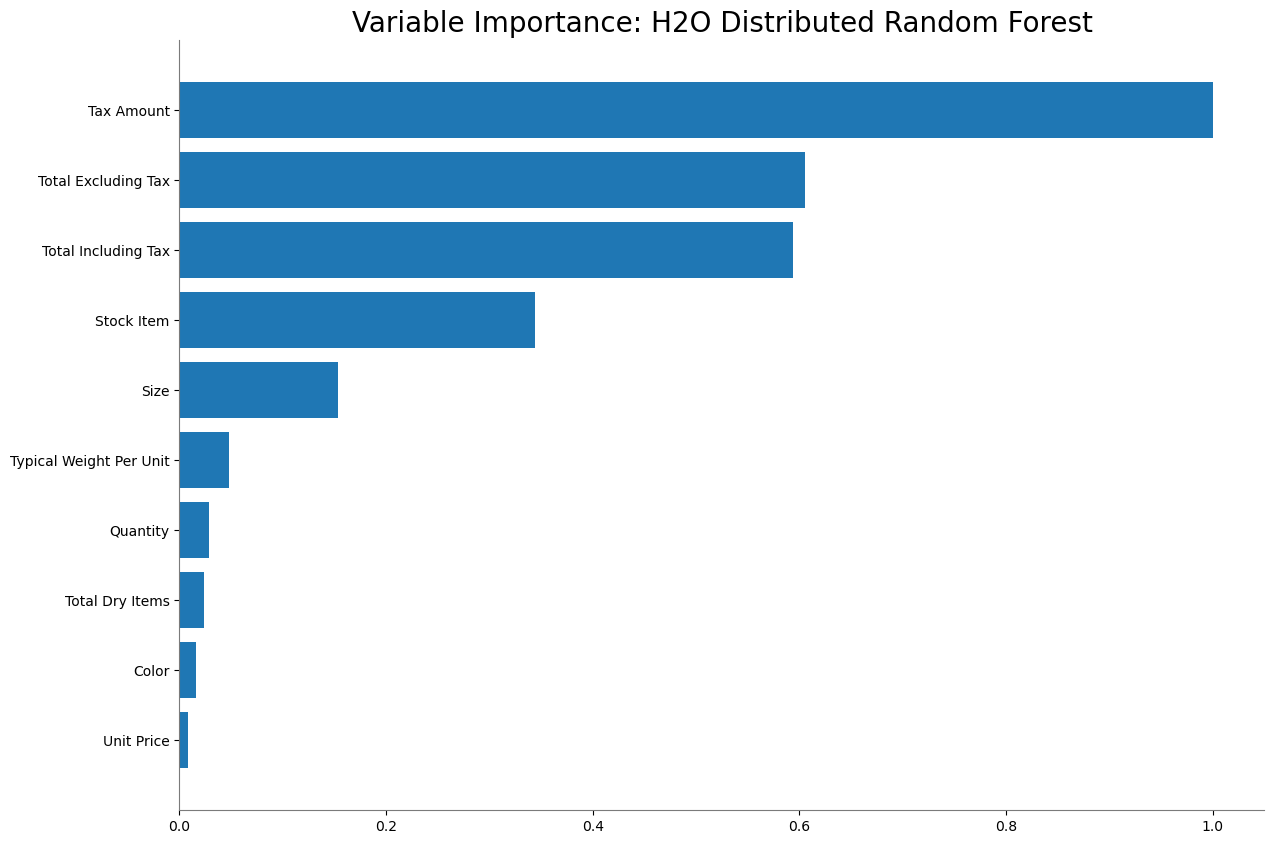

<Figure size 640x480 with 0 Axes>

In [17]:
ra_plot = aml.leader.varimp_plot()

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

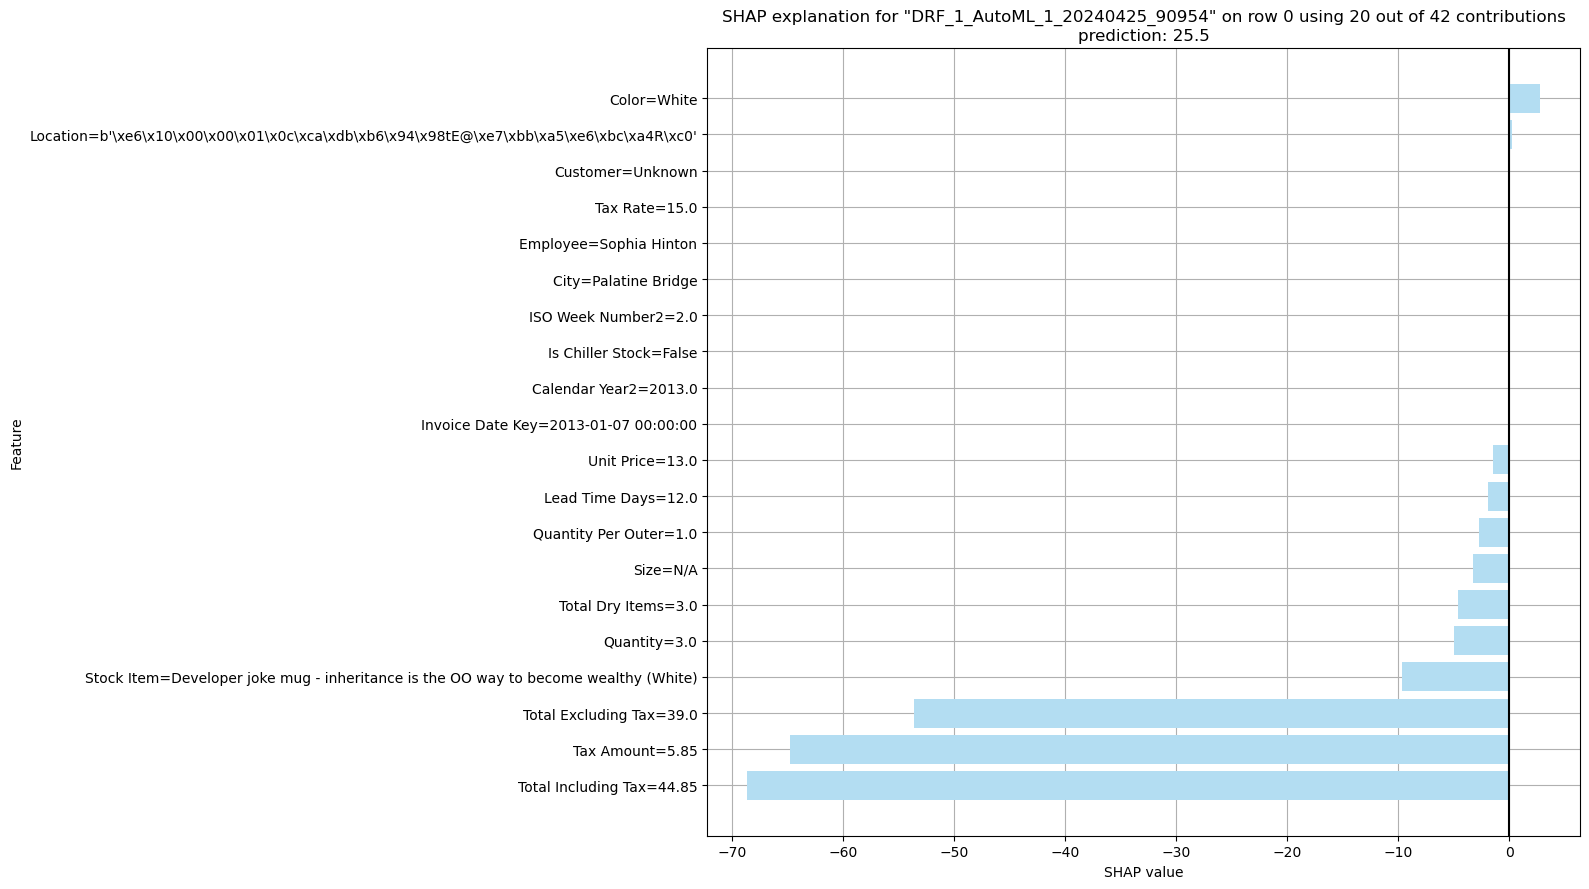

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

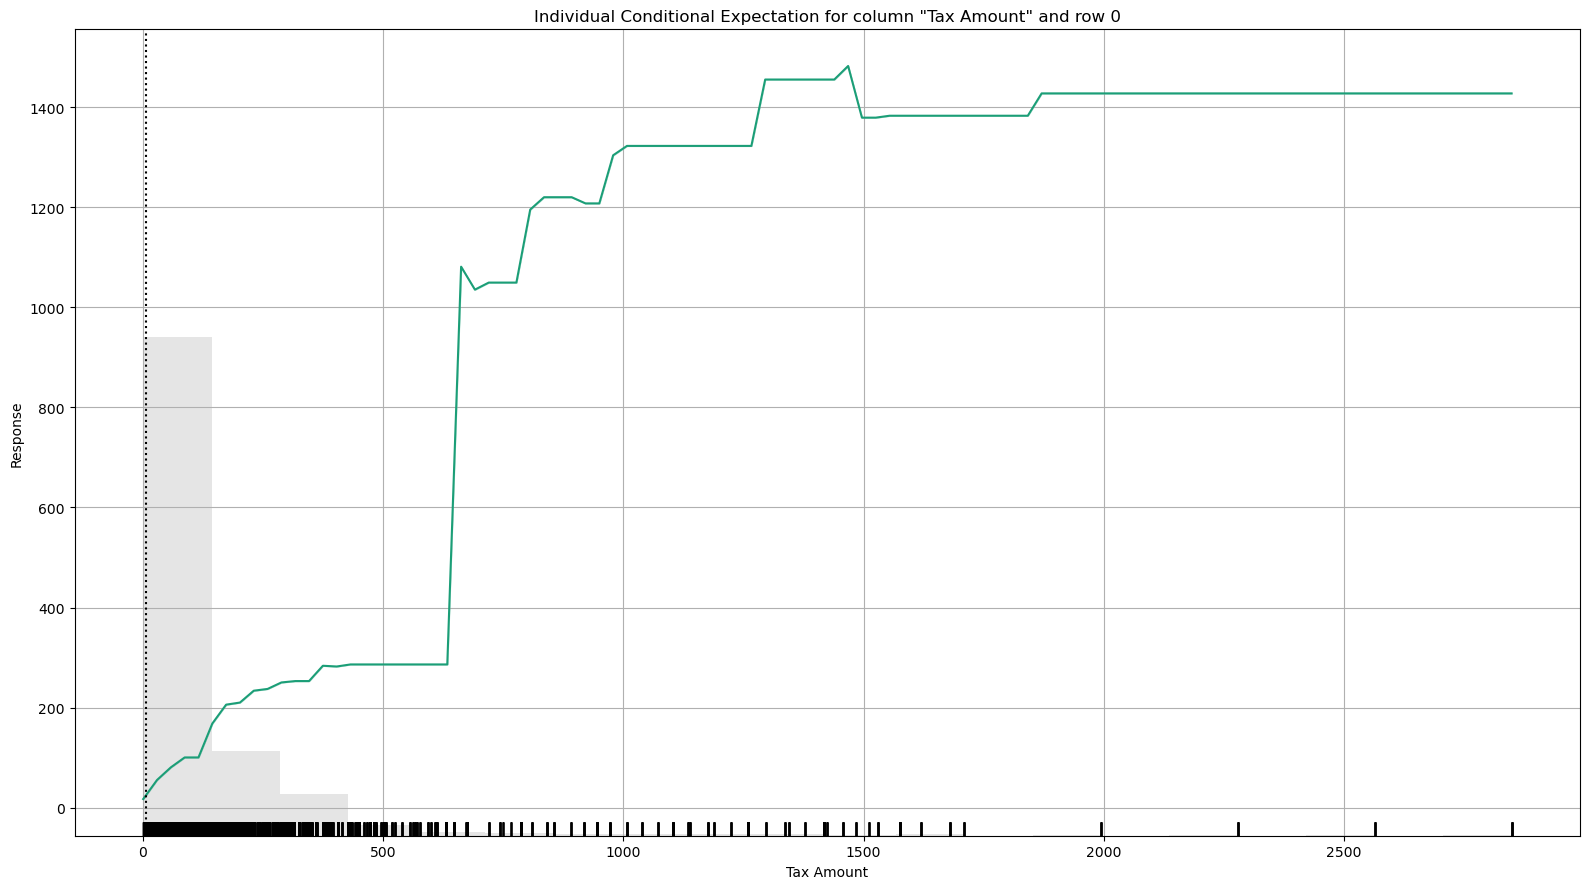

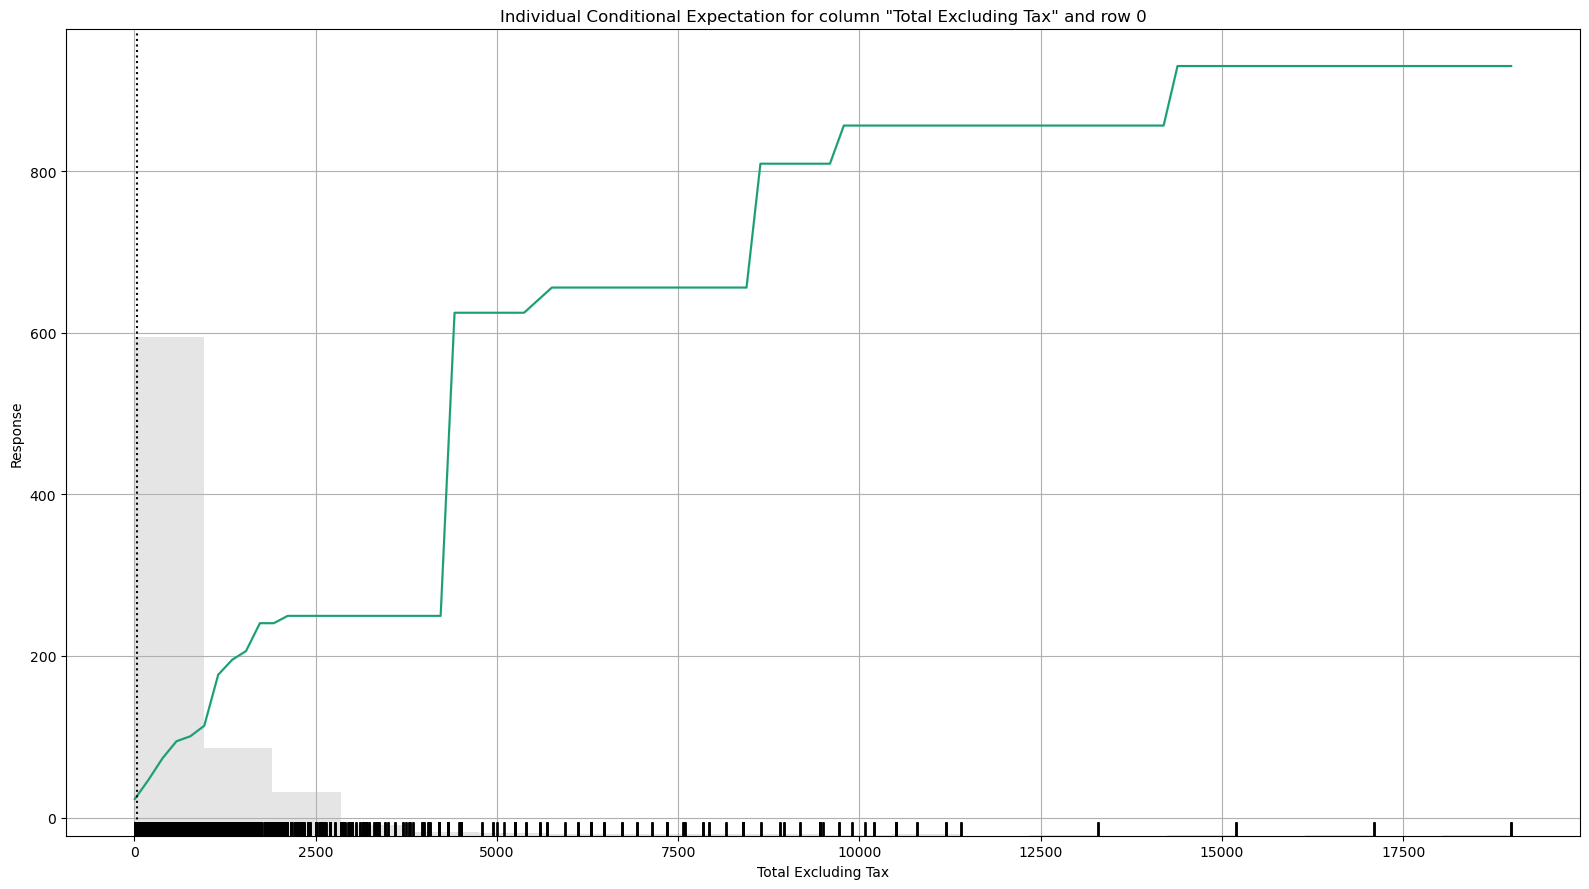

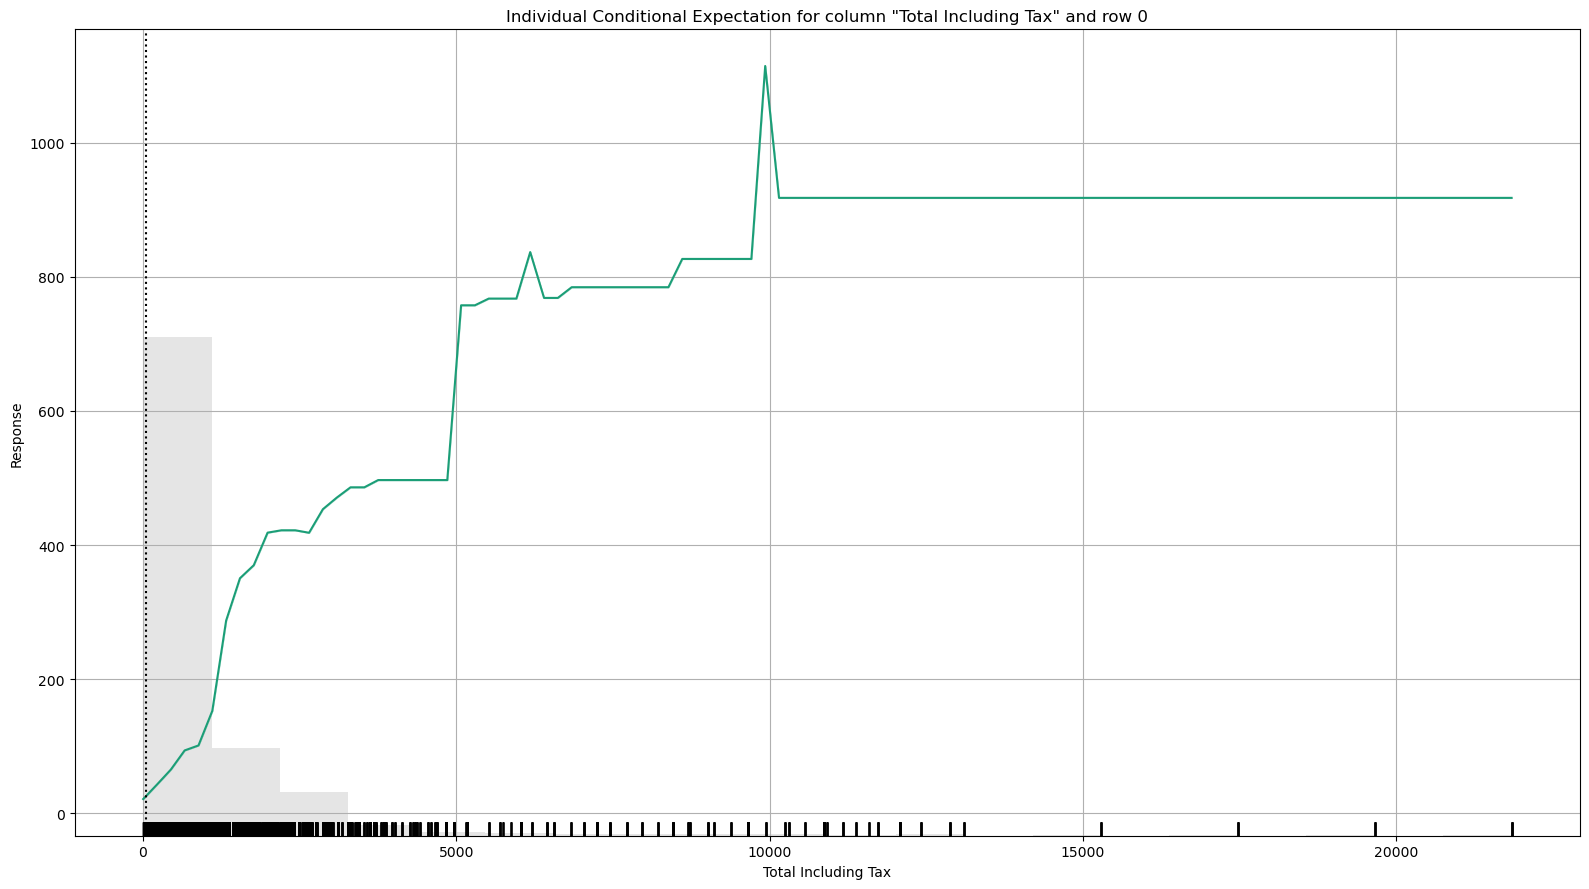

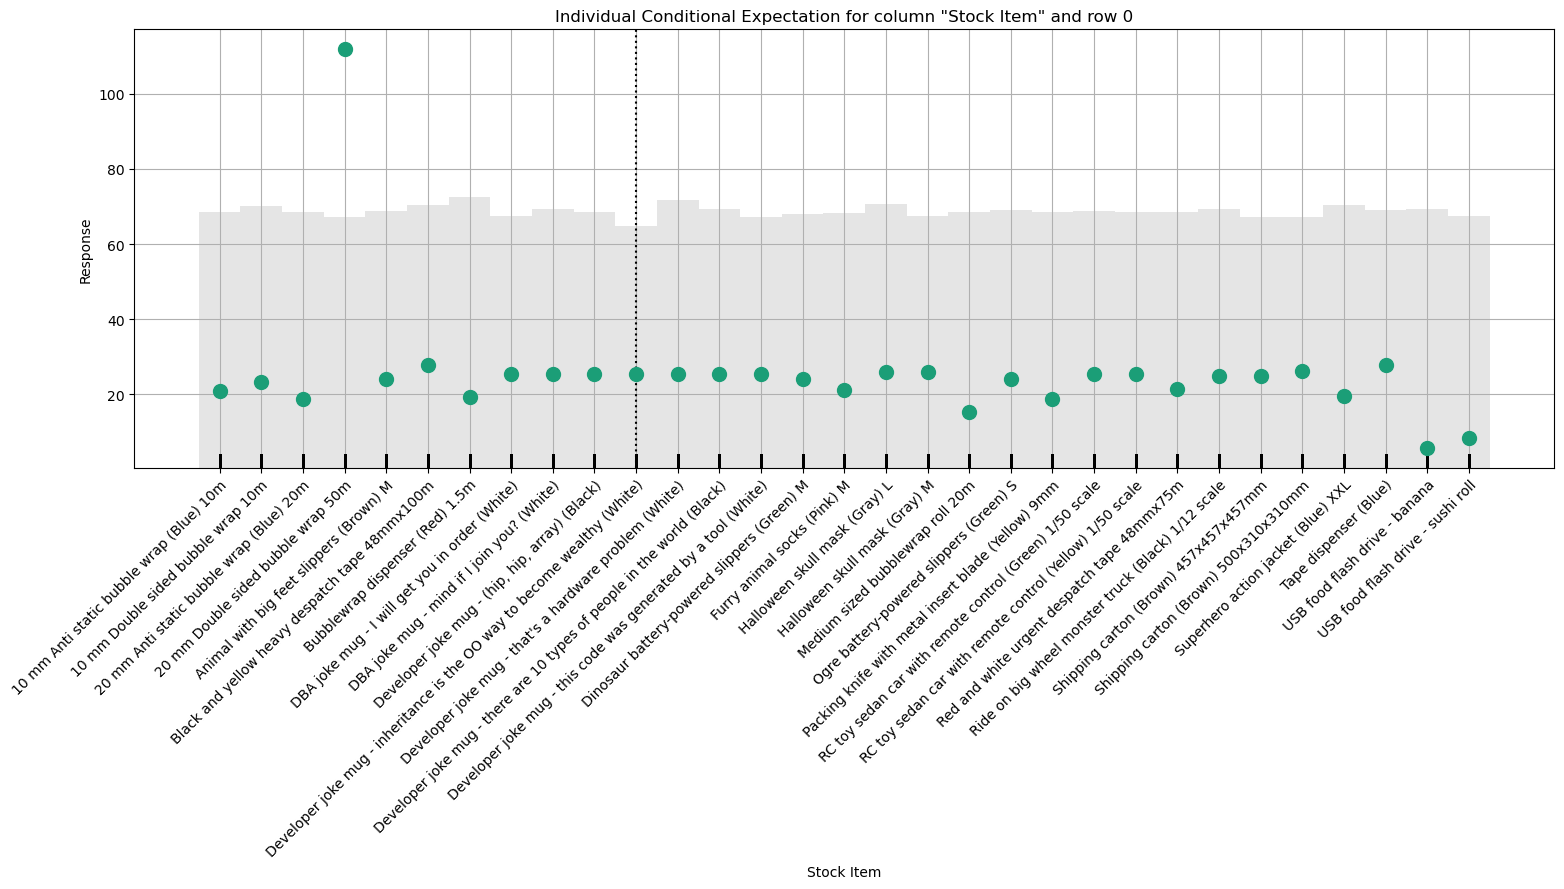

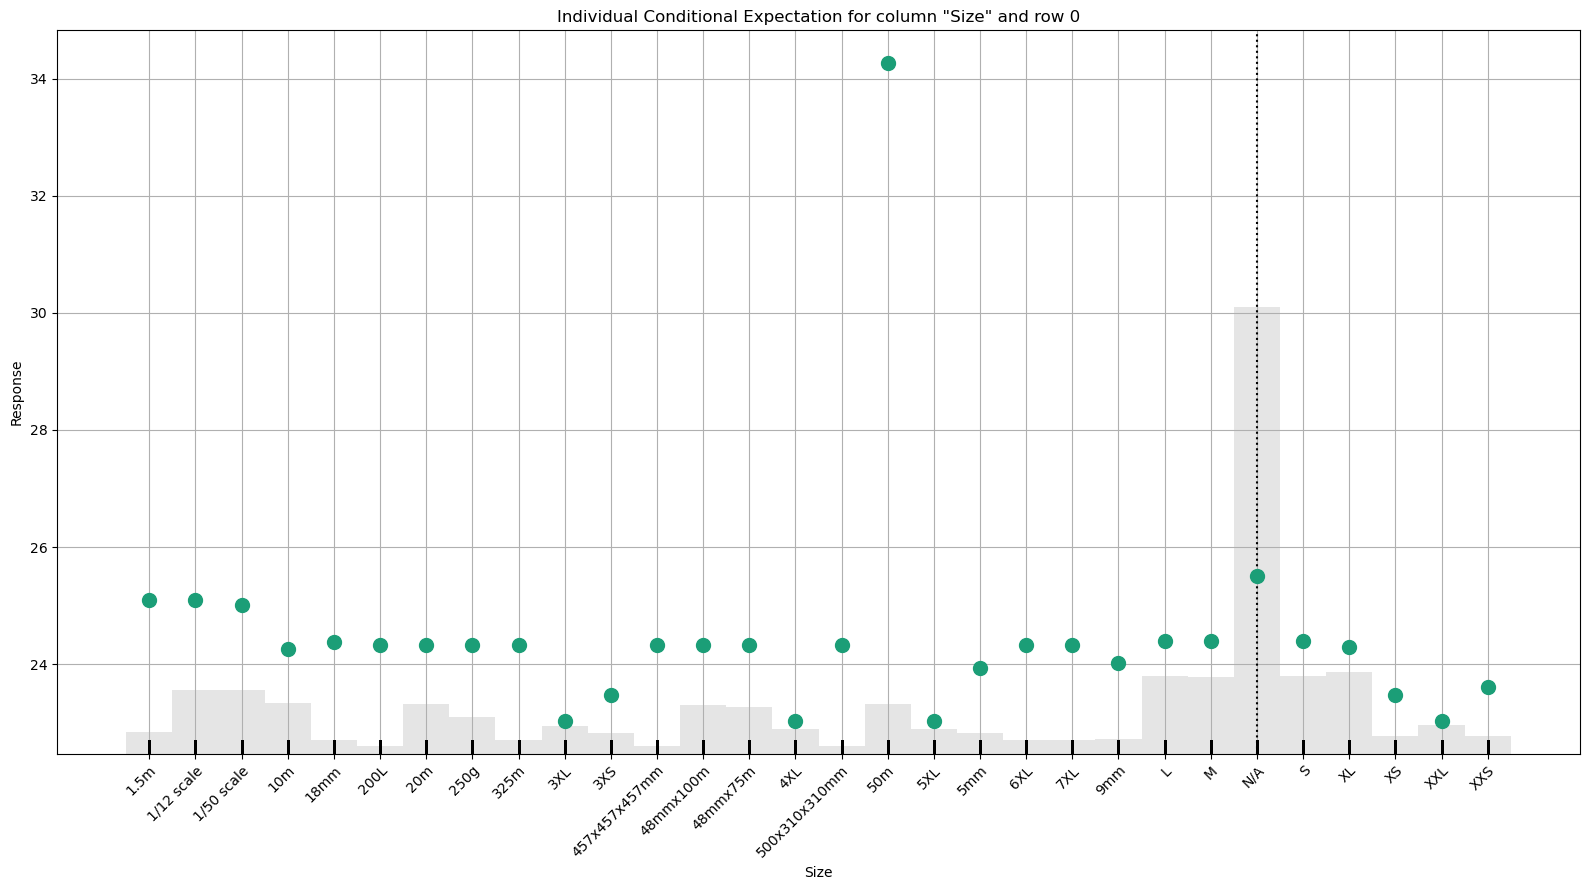

In [19]:
exl = aml.leader.explain_row(test, row_index=0)